# Logistic map

In [3]:
# This is a standard initalisation code - no need to change this
# It loads basic fast array code, plot library and ODE solver
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import jit
%matplotlib inline
%config InlineBackend.figure_formats={'retina','png'}

Defining the map instelf $x_{n+1}=r x_n(1-x_n)$

In [38]:
def lmap(x,r):
    return r*x*(1-x)

## Cobwebs

In [39]:
def plot_cobweb(r, x0=0.25, npoints=500):    
    xran=np.linspace(0,1, num=100)

    fig1, ax1 = plt.subplots(1) # get figure and "axes". They can be reused later.
    ax1.plot(xran, xran)
    ax1.plot(xran, lmap(xran,r))
    ax1.set_xlabel("$x_n$")
    ax1.set_ylabel("$x_{n+1}$")

    # Initial iterations in green
    x = x0
    for i in range(npoints):
        x2 = lmap(x, r)
        ax1.plot([x,x,x2],[x,x2,x2], color="green", linewidth=0.5)
        x = x2
    # limit cycle in black
    for i in range(npoints):
        x2 = lmap(x, r)
        ax1.plot([x,x,x2],[x,x2,x2], color="black", linewidth=0.5)
        x = x2

The iterations converge fast for smaller $r$

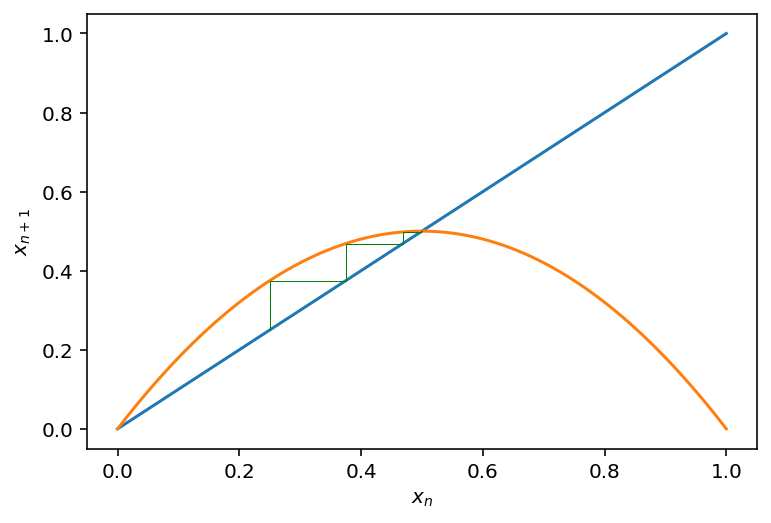

In [40]:
plot_cobweb(2)

Approach a cycle for larger $r$

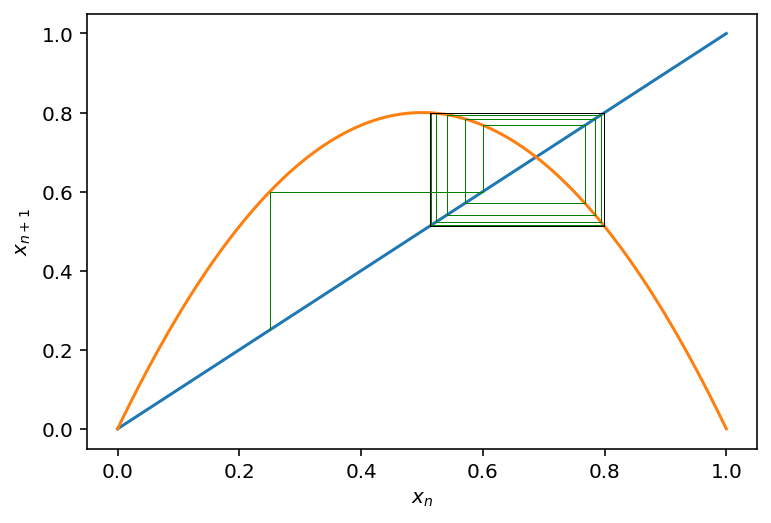

In [41]:
plot_cobweb(3.2)

And are chaotic for even larger $r$

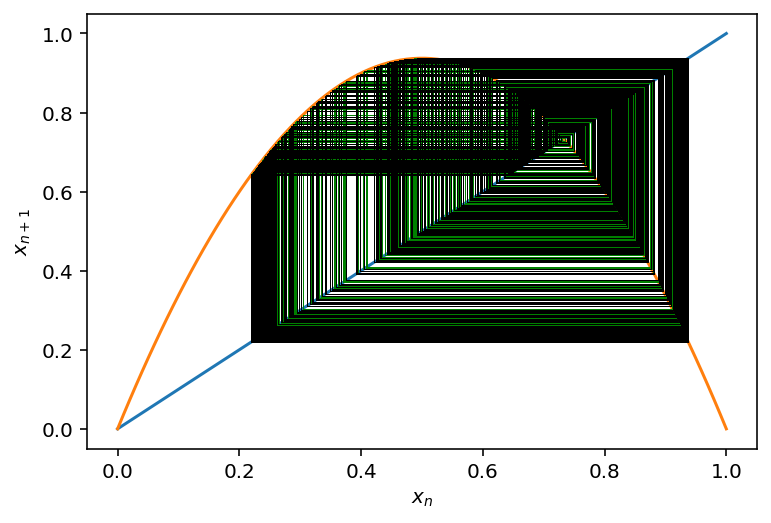

In [42]:
plot_cobweb(3.75)

## The limiting points for all $r$

Function returning the limit cycle -- iterate for some (1000) iterations to get to the limit cycle, and then iterate next bunch of iterations to get the cycle.

In [66]:
def get_cycle(r, x0=0.25, npoints=1000):
    x = x0
    for i in range(npoints):
        x = lmap(x,r)
    cycles = np.empty(npoints)
    for i in range(npoints):
        x = lmap(x,r)
        cycles[i] = x
    return np.unique(cycles)

An let us plot the map!

CPU times: user 7.91 s, sys: 1.88 ms, total: 7.91 s
Wall time: 7.93 s


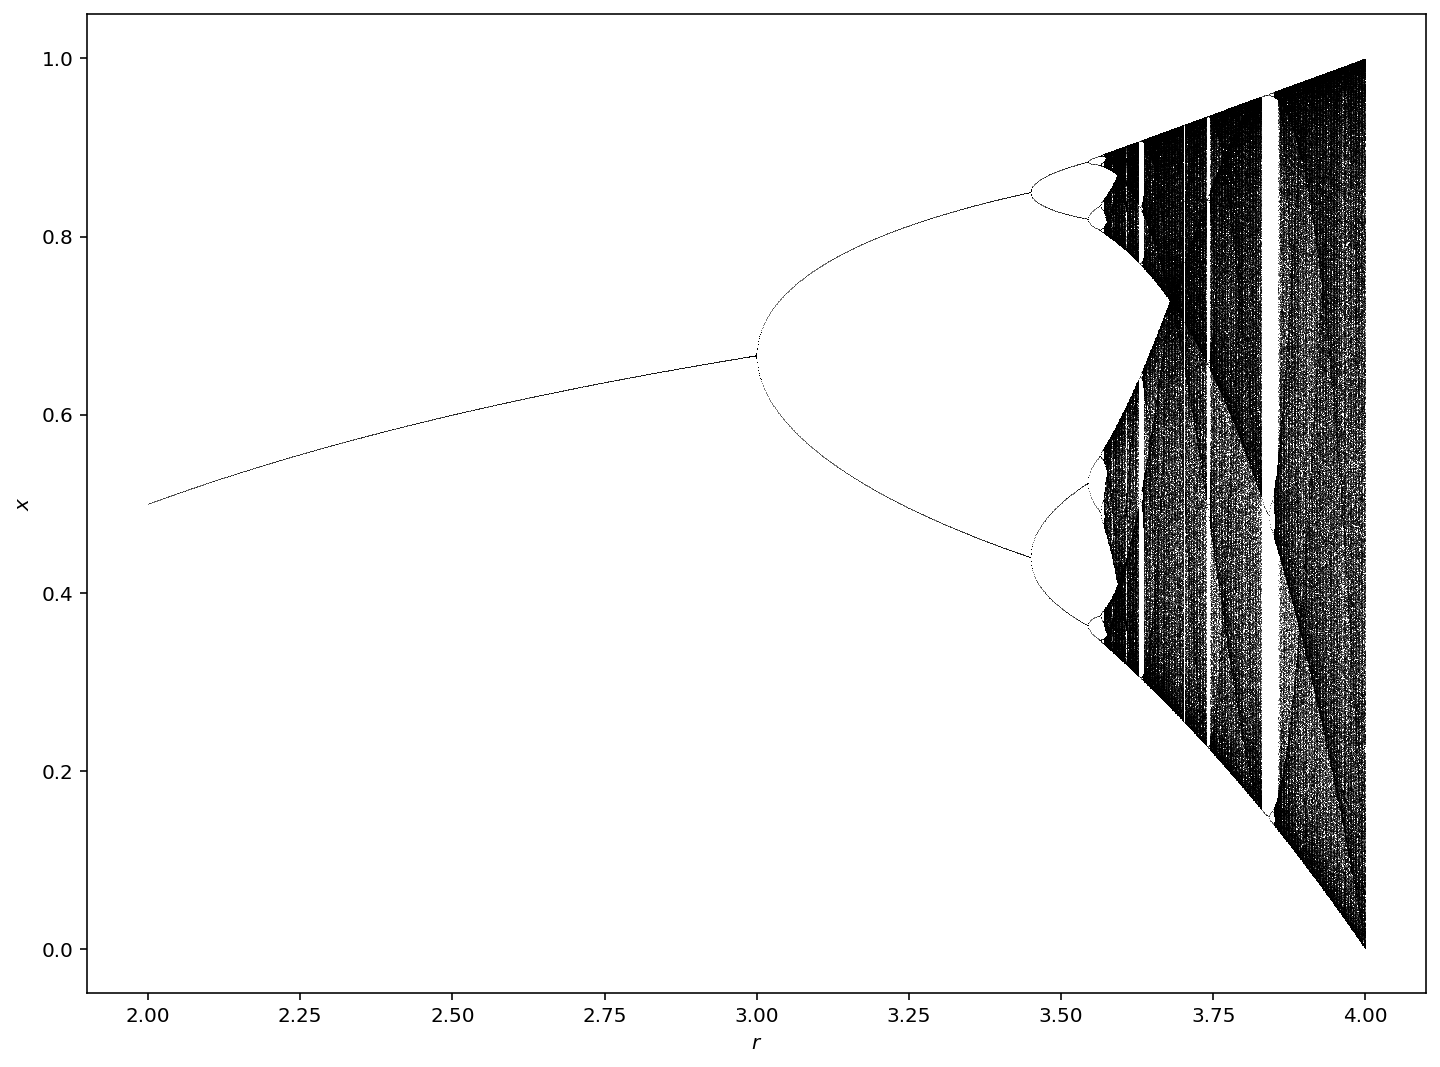

In [78]:
rran=np.linspace(2, 4, num=2000) # You can change the range to "zoom"
## rran=np.linspace(3.5, 3.7, num=1000)

def plotthemap(rran, cyclepoints=2000):
    fig2 = plt.figure(figsize=(12, 9))
    ax2 = fig2.subplots(1) # get figure and "axes". They can be reused later.
    ax2.set_xlabel("$r$")
    ax2.set_ylabel("$x$")
    for r in rran:
        cycle = get_cycle(r, npoints=cyclepoints)
        rr = np.full_like(cycle, r)
        ax2.scatter(rr, cycle, lw=0, s=0.1, color="black")
        
%time plotthemap(rran)

## Speeding things up

(for interested in python)

The last plot was a bit slow. We can actually speed things a bit up by using NUMBA -- precompiling Python function. It is rather easy -- you can add `@jit` in front of functions that do a lot of work

In [69]:
@jit
def fast_lmap(x,r):
    return r*x*(1-x)

In [70]:
@jit
def fast_get_cycle(r, x0=0.25, npoints=1000):
    x = x0
    for i in range(npoints):
        x = fast_lmap(x,r)
    cycles = np.empty(npoints)
    for i in range(npoints):
        x = fast_lmap(x,r)
        cycles[i] = x
    return np.unique(cycles)

CPU times: user 5.66 s, sys: 3.94 ms, total: 5.66 s
Wall time: 5.67 s


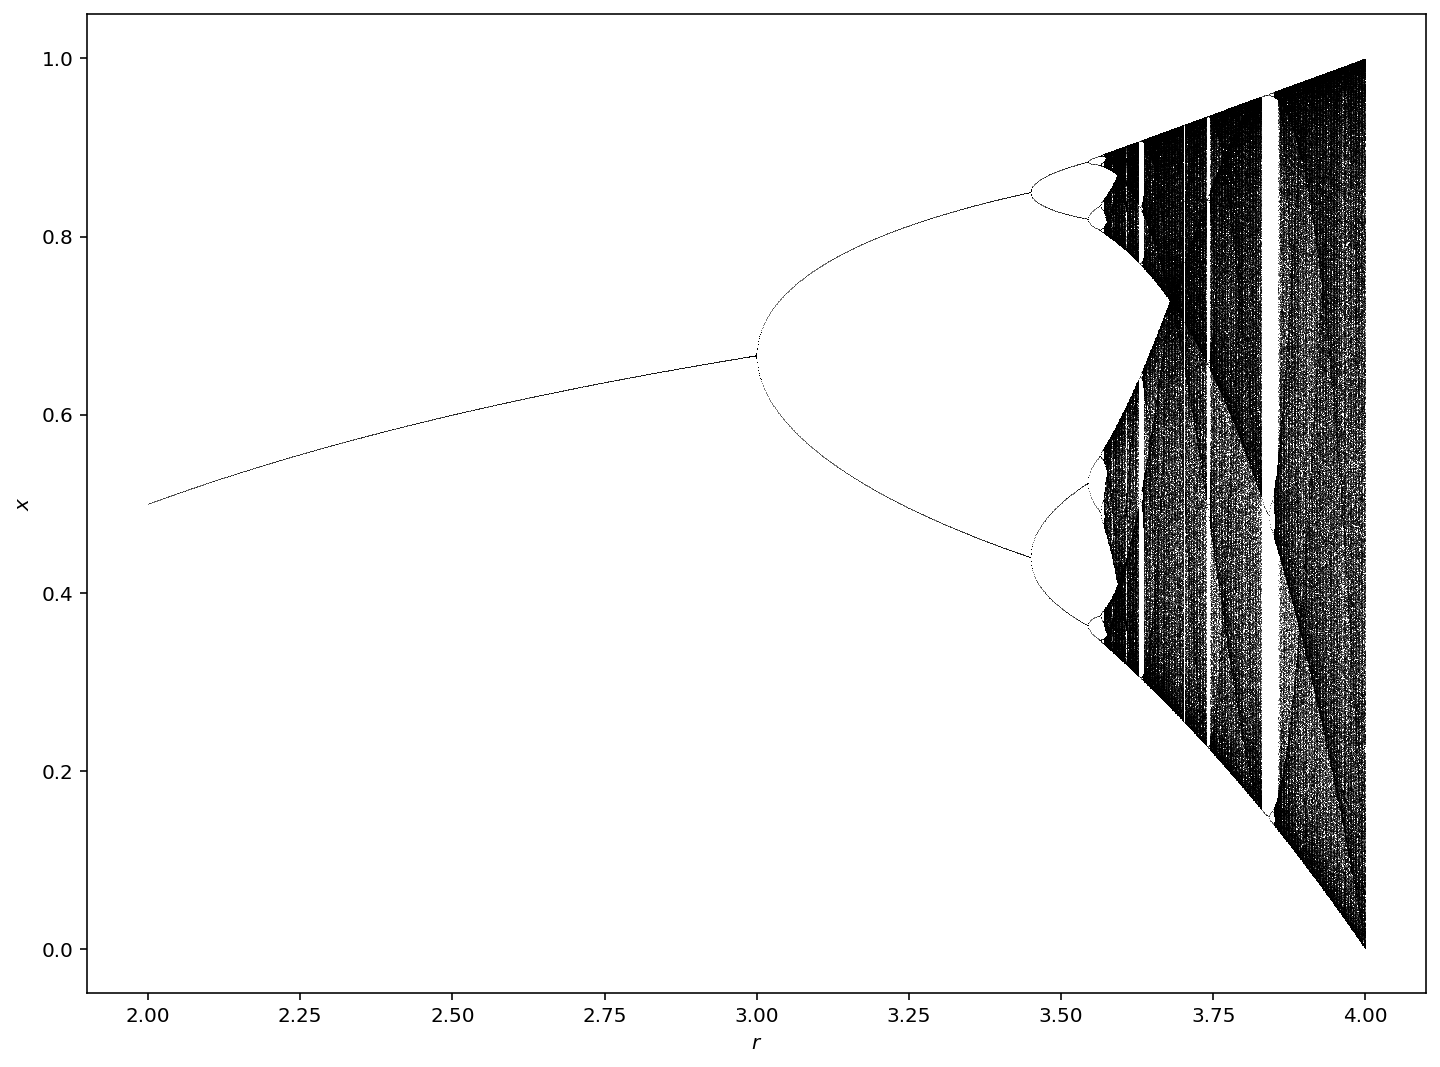

In [80]:
rran=np.linspace(2, 4, num=2000) # You can change the range to "zoom"
## rran=np.linspace(3.5, 3.7, num=1000)

def plotthemap_faster(rran, cyclepoints=2000):
    fig2 = plt.figure(figsize=(12, 9))
    ax2 = fig2.subplots(1) # get figure and "axes". They can be reused later.
    ax2.set_xlabel("$r$")
    ax2.set_ylabel("$x$")
    for r in rran:
        cycle = fast_get_cycle(r, npoints=cyclepoints)
        rr = np.full_like(cycle, r)
        ax2.scatter(rr, cycle, lw=0, s=0.1, color="black")
        
%time plotthemap_faster(rran)

It is faster already, but let us do all the calcualtions first, and then plot everything, instead of calling the plot function for each $r$. This requires a bit of extra coding to collect the arrays for the values of $r$ and fixed points for each $r$ in the long `rr` and `rx` arrays, but it pays off.

CPU times: user 745 ms, sys: 8.99 ms, total: 754 ms
Wall time: 752 ms


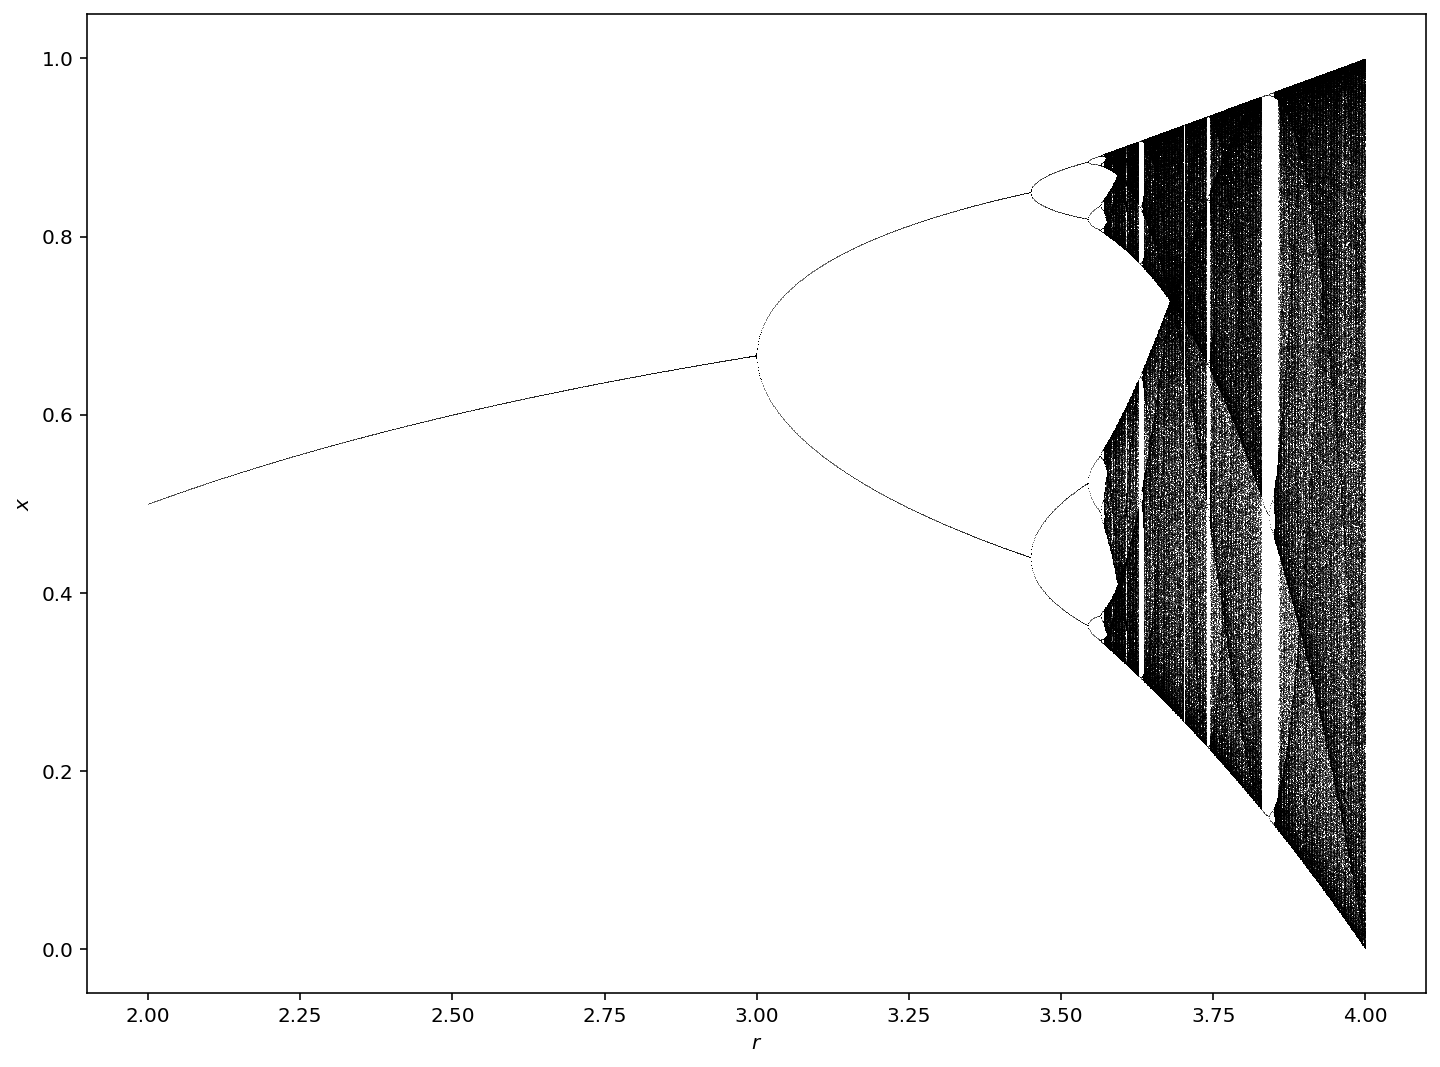

In [83]:
rran=np.linspace(2, 4, num=2000) # You can change the range to "zoom"
## rran=np.linspace(3.5, 3.7, num=1000)

@jit
def get_logistic_map(rran, cyclepoints=2000):
    rr = np.empty(0)
    rx = np.empty(0)
    for r in rran:
        cycle = fast_get_cycle(r, npoints=cyclepoints)
        rr = np.concatenate((rr, np.full_like(cycle, r)))
        rx = np.concatenate((rx, cycle))
    return (rr,rx)

# Note, we can not do @jit here -- only numeric code can be accelerated, not plotting
def plotthemap_fastest(rran, cyclepoints=2000):
    fig2 = plt.figure(figsize=(12, 9))
    ax2 = fig2.subplots(1) # get figure and "axes". They can be reused later.
    ax2.set_xlabel("$r$")
    ax2.set_ylabel("$x$")
    rr, rx = get_logistic_map(rran, cyclepoints)
    ax2.scatter(rr, rx, lw=0, s=0.1, color="black")

%time plotthemap_fastest(rran)

Now that is much faster!